<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Adapted from: https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb

In [1]:
import pandas as pd
import numpy as np
import os

names = ['time', 'u' , 'x', 'obs_num']

path = r"C:\Users\sian_\OneDrive\Documents\Thesis\MILP_Formulation\Optimal_Control_Toy"
df = pd.read_csv("data_N200.csv",sep=',', header=0, names=names,index_col=False)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.bfill(inplace=True)
df.ffill(inplace=True) #for obs num


print("Starting file:")
print(df[0:10])

print("Ending file:")
print(df[-10:])

print(df.shape)

Starting file:
       time         u         x  obs_num
0  0.000000  0.250000  1.000000      1.0
1  0.000111  0.250014  1.000118      1.0
2  0.000222  0.250028  1.000236      1.0
3  0.000333  0.250042  1.000354      1.0
4  0.000444  0.250056  1.000472      1.0
5  0.000556  0.250069  1.000590      1.0
6  0.000667  0.250083  1.000708      1.0
7  0.000778  0.250097  1.000826      1.0
8  0.000889  0.250111  1.000945      1.0
9  0.001000  0.250125  1.001063      1.0
Ending file:
           time         u         x  obs_num
26990  0.999000  1.998000  3.328337      3.0
26991  0.999111  1.998222  3.328892      3.0
26992  0.999222  1.998444  3.329446      3.0
26993  0.999333  1.998667  3.330001      3.0
26994  0.999444  1.998889  3.330556      3.0
26995  0.999556  1.999111  3.331112      3.0
26996  0.999667  1.999333  3.331667      3.0
26997  0.999778  1.999556  3.332222      3.0
26998  0.999889  1.999778  3.332778      3.0
26999  1.000000  2.000000  3.333333      3.0
(27000, 4)


In [2]:
# import math

# def PE(j, d_model):
#     PE_list = []
#     for i, value in enumerate(df['time']):
#         if i % 2 == 0:
#             PE_list += [ math.sin(value/ (10000**(2*j / d_model)))]
#         else:
#             PE_list += [ math.cos(value/ (10000**(2*j / d_model)))]
            
#     return PE_list

# df['x_'] = df['x']
# df['u_'] = df['u']
# df['x'] = df['x'] + np.array(PE(0, 2))
# df['u'] = df['u'] + np.array(PE(1, 2))

df.head()

,time,u,x,obs_num
0,0.000000,0.250000,1.000000,1.0
1,0.000111,0.250014,1.000118,1.0
2,0.000222,0.250028,1.000236,1.0
3,0.000333,0.250042,1.000354,1.0
4,0.000444,0.250056,1.000472,1.0


In [3]:
# # Find the last zero and move one beyond
# start_id = max(df[df['obs_num'] == 0].index.tolist())+1
# print(start_id)
# df = df[start_id:] # Trim the rows that have missing observations

Divide into training and test/validation sets.

In [4]:
df['u'] = df['u'].astype(float)
df12 = df[df['obs_num']<3.0]
df123 = df[df['obs_num']<4.0]

df_train = df123[df123['time']<0.7]
df_test = df123[df123['time']>=0.7]

spots_train_u = df_train['u'].tolist()
spots_train_x = df_train['x'].tolist()
spots_train_t = df_train['time'].tolist()

spots_test_u = df_test['u'].tolist()
spots_test_x = df_test['x'].tolist()
spots_test_t = df_test['time'].tolist()

print("Training set has {} observations.".format(len(spots_train_u)))
print("Test set has {} observations.".format(len(spots_test_u)))
# print(spots_train)

Training set has 18900 observations.
Test set has 8100 observations.


In [5]:

df1 = df[df['obs_num']==1.0]
df2 = df[df['obs_num']==2.0]
df3 = df[df['obs_num']==3.0]

df_test1 = df1[df1['time']>=0.7]
df_test2 = df2[df2['time']>=0.7]
df_test3 = df3[df3['time']>=0.7]

spots_test1_u = df_test1['u'].tolist()
spots_test1_x = df_test1['x'].tolist()
spots_test1_t = df_test1['time'].tolist()

spots_test2_x = df_test2['x'].tolist()
spots_test2_u = df_test2['u'].tolist()
spots_test2_t = df_test2['time'].tolist()

spots_test3_x = df_test3['x'].tolist()
spots_test3_u = df_test3['u'].tolist()
spots_test3_t = df_test3['time'].tolist()

print("Test set 1 has {} observations.".format(len(spots_test1_u)))
print("Test set 2 has {} observations.".format(len(spots_test2_u)))
print("Test set 3 has {} observations.".format(len(spots_test3_u)))

Test set 1 has 2700 observations.
Test set 2 has 2700 observations.
Test set 3 has 2700 observations.


The **to_sequences** function takes linear time series data into an **x** and **y** where **x** is all possible sequences of seq_size. After each **x** sequence, this function places the next value into the **y** variable. These **x** and **y** data can train a time-series neural network.

In [41]:
import numpy as np

def to_sequences(SEQUENCE_SIZE, obs_x, obs_u, obs_t):

    x = []
    y = []
    for i in range((len(obs_x))-SEQUENCE_SIZE):

        window1 = obs_x[i:(i+SEQUENCE_SIZE)]  #[i:(i+SEQUENCE_SIZE)] 
        window2 = obs_u[i:(i+SEQUENCE_SIZE)] 
        after_window = [obs_x[i+SEQUENCE_SIZE]] 
        window = [[x, t] for x,t in zip(window1, window2)]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x),np.array(y)

SEQUENCE_SIZE = 4
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train_x, spots_train_u, spots_train_t)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test_x, spots_test_u, spots_test_t)

print("Shape of x train set: {}".format(x_train.shape))
print("Shape of x test set: {}".format(x_test.shape))

print("Shape of y train set: {}".format(y_train.shape))
print("Shape of y test set: {}".format(y_test.shape))

Shape of x train set: (18895, 5, 2)
Shape of x test set: (8095, 5, 2)
Shape of y train set: (18895, 1)
Shape of y test set: (8095, 1)


In [42]:

x_test1, y_test1 = to_sequences(SEQUENCE_SIZE,spots_test1_x, spots_test1_u ,  spots_test1_t)
print("Shape of y1 test set: {}".format(y_test1.shape))

x_test2, y_test2 = to_sequences(SEQUENCE_SIZE,spots_test2_x, spots_test2_u,  spots_test1_t)
print("Shape of y2 test set: {}".format(y_test2.shape))

x_test3, y_test3 = to_sequences(SEQUENCE_SIZE,spots_test3_x, spots_test3_u,  spots_test1_t)
print("Shape of y3 test set: {}".format(y_test3.shape))

Shape of y1 test set: (2695, 1)
Shape of y2 test set: (2695, 1)
Shape of y3 test set: (2695, 1)


We can view the results of the **to_sequences** encoding of the sunspot data.

In [43]:

# print('func 1',x_train[0])
# print('func 2',x_train[1])

In [44]:
#!pip install tensorflow

Next, we create the transformer_encoder; I obtained this function from a [Keras example](https://keras.io/examples/timeseries/timeseries_transformer_classification/). This layer includes residual connections, layer normalization, and dropout. This resulting layer can be stacked multiple times. We implement the projection layers with the Keras Conv1D.

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    ## NB dropout layer is only applied during training not inference (https://keras.io/api/layers/regularization_layers/dropout/)
    
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    # x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    # x = layers.Dropout(dropout)(x)
    # x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1], activation="relu")(x)
    
    #x = layers.Conv2D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    #x = layers.Dropout(dropout)(x)
    #x = layers.Conv2D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res

In [47]:
def transformer_decoder(inputs, encoder_outputs, head_size, num_heads, ff_dim, dropout=0):
    # Masked multi-head self-attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x, attention_mask=create_look_ahead_mask(x.shape[1]))
    x = layers.Dropout(dropout)(attention_output)
    res = x + inputs

    # Cross-attention with encoder outputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    attention_output = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, encoder_outputs)
    x = layers.Dropout(dropout)(attention_output)
    res = x + res

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    
    return x + res

def create_look_ahead_mask(size):
    mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0) #1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    print(mask)
    return mask

The following function is provided to build the model, including the attention layer.

In [58]:


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.25,
    mlp_dropout=0.25,
):
   

    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = layers.Dense(10)(inputs)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    encoder_outputs = x
    
    # Decoder
    decoder_inputs = keras.Input(shape=input_shape)
    x = decoder_inputs
    x = layers.Dense(10)(decoder_inputs)
    for _ in range(num_transformer_blocks):
        x = transformer_decoder(x, encoder_outputs, head_size, num_heads, ff_dim, dropout)
    decoder_outputs = x
    
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    #x = layers.GlobalAveragePooling2D(data_format="channels_first")(x)
    print(x.shape, x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="relu")(x)
    return keras.Model(inputs= [inputs, decoder_inputs], outputs = outputs)

In [113]:
# model parameters:
model_params = {
    'input_shape': (SEQUENCE_SIZE,2),
    'head_size': 1,
    'num_heads': 5,
    'ff_dim': 8, #32
    'num_transformer_blocks': 1,
    'mlp_units': [12], #24
    'mlp_dropout': 0,
    'dropout': 0.25,
    'validation_split': 0.2,
    'epochs':1000,
    'batch_size': 32,
    'learning_rate': 1e-7
}
"""
model_params = {
    'input_shape': x_train.shape[1:],
    'head_size': 10,
    'num_heads': 4,
    'ff_dim': 4,
    'num_transformer_blocks': 1,
    'mlp_units': [128],
    'mlp_dropout': 0,
    'dropout': 0,
    'validation_split': 0.2,
    'epochs': 200,
    'batch_size': 64,
    'learning_rate': 1e-3
}
"""

print(x_train[0,:,0].shape)

(5,)


We are now ready to build and train the model.

In [114]:


model = build_model(
    input_shape = model_params["input_shape"],
    head_size = model_params["head_size"],
    num_heads = model_params["num_heads"],
    ff_dim = model_params["ff_dim"],
    num_transformer_blocks = model_params['num_transformer_blocks'],
    mlp_units = model_params["mlp_units"],
    mlp_dropout = model_params["mlp_dropout"],
    dropout = model_params["dropout"],
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=model_params['learning_rate'])
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=2, \
    restore_best_weights=True)]

model.fit(
    [x_train, x_train],
    y_train,
    validation_split = model_params["validation_split"],
    epochs = model_params["epochs"],
    batch_size = model_params["batch_size"],
    callbacks=callbacks,
    shuffle=True,
)

model.evaluate([x_test, x_test], y_test, verbose=0)

tf.Tensor(
[[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]], shape=(5, 5), dtype=float32)
(None, 10) <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_346>


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 5, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_78 (Dense)    │ (None, 5, 10)     │         30 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 10)     │         20 │ dense_78[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 10)     │      1,300 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 5, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_100         │ (None, 5, 10)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 5, 10)     │         30 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_55 (Add)        │ (None, 5, 10)     │          0 │ dropout_100[0][0… │
│                     │                   │            │ dense_78[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 10)     │         20 │ dense_81[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 10)     │         20 │ add_55[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 10)     │      1,300 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_79 (Dense)    │ (None, 5, 10)     │        110 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_103         │ (None, 5, 10)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_101         │ (None, 5, 10)     │          0 │ dense_79[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_57 (Add)        │ (None, 5, 10)     │          0 │ dropout_103[0][0… │
│                     │                   │            │ dense_81[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 5, 10)     │        110 │ dropout_101[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 10)     │         20 │ add_57[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_56 (Add)        │ (None, 5, 10)     │          0 │ dense_80[0][0],   │
│                     │                   │            │ add_55[0][0]    

 Total params: 6,037 (23.58 KB)

 Trainable params: 6,037 (23.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
630/630 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.9594 - val_loss: 1.6837
Epoch 2/1000
630/630 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.9534 - val_loss: 1.6636
Epoch 3/1000
630/630 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.9376 - val_loss: 1.6435
Epoch 4/1000
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.9172 - val_loss: 1.6235
Epoch 5/1000
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.8964 - val_loss: 1.6037
Epoch 6/1000
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.8894 - val_loss: 1.5838
Epoch 7/1000
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.8757 - val_loss: 1.5641
Epoch 8/1000
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.8591 - val_loss: 1.5444
Epoch 9/1000
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.8478 - val_loss: 1.5249
Epoch 10/1000
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.8256 - val_loss: 1.5054
Epoch 11/1000
630/630 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.8188 - val_loss: 1.4861
Epoch 12/1000
630/

0.12923173606395721

Finally, we evaluate the model with RMSE.

In [115]:
name = 'TNN_ed.keras'
model.save(name , overwrite=True)

In [116]:
from sklearn import metrics

#score_x = np.sqrt(metrics.mean_squared_error(pred[:,0],y_test[:,0]))
#print("X Score (RMSE): {}".format(score_x))

#score_u = np.sqrt(metrics.mean_squared_error(pred[:,1],y_test[:,1]))
#print("U Score (RMSE): {}".format(score_u))

In [117]:
preds_x = []
rmse_x = []
preds_u = []
rmse_u = []


for x,y in [[x_test1, y_test1],[x_test2, y_test2],[x_test3, y_test3]]:
    pred = model.predict([x,x])

    score_x = np.sqrt(metrics.mean_squared_error(pred[:,0],y[:,0]))
    print("X Score (RMSE): {}".format(score_x))
    preds_x.append(pred[:,0])
    rmse_x.append(score_x)
    try:
        score_u = np.sqrt(metrics.mean_squared_error(pred[:,1],y[:,1]))
        print("U Score (RMSE): {}".format(score_u))
        preds_u.append(pred[:,1])
        rmse_u.append(score_u)
    except:
        continue

print('Prediction shape: ', len(preds_x))

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
X Score (RMSE): 0.11758454689317473
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
X Score (RMSE): 0.20684359291590151
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
X Score (RMSE): 0.5757268254120098
Prediction shape:  3


In [118]:
import csv
# New filename for clarity
new_filename = "TNN_copy.csv"

# Create and write to the new CSV file with model parameters and results
with open(new_filename, 'a', newline='') as file:
    writer = csv.writer(file)
    # Writing headers for model parameters
    headers = list(model_params.keys())
    headers.append('rmse_x_1')
    headers.append('rmse_x_2')
    headers.append('rmse_x_3')

    headers.append(name)
    writer.writerow(headers)
    
    # Writing values
    values = list(model_params.values())
    values.append(rmse_x[0])  # Adding first RMSE
    values.append(rmse_x[1])  # Adding second RMSE
    values.append(rmse_x[2])  
    # values.append(rmse_u[0])  # Adding first RMSE
    # values.append(rmse_u[1])  # Adding second RMSE
    # values.append(rmse_u[2])
    values.append('')
    writer.writerow(values)

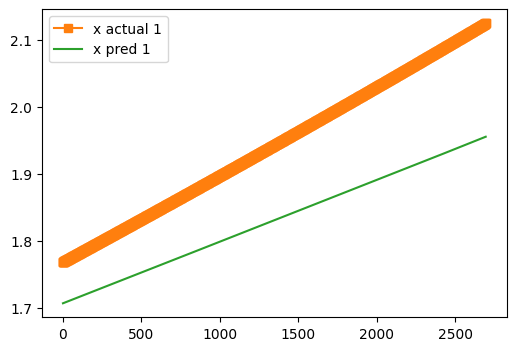

In [119]:
import matplotlib.pyplot as plt
func = 0
plt.figure(figsize=(6, 4))
plt.plot(y_test1[:,0], 's-',color='C1', label=f'x actual {func+1}')
plt.plot(preds_x[func], '-',color='C2', label=f'x pred {func+1}')

try:
    plt.plot(y_test1[:,1], 's-',color='C0', label=f'u actual {func+1}')
    plt.plot(preds_u[func], '-',color='C3', label=f'u pred {func+1}')
except:
    pass
plt.legend()

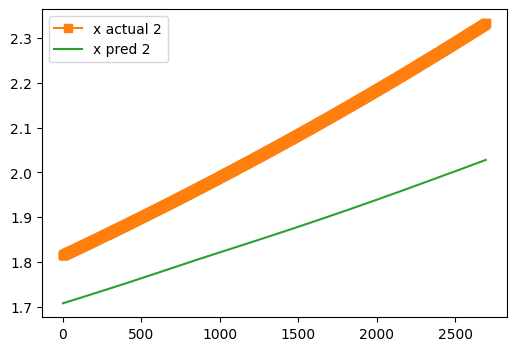

In [120]:
import matplotlib.pyplot as plt
func = 1
plt.figure(figsize=(6, 4))
plt.plot(y_test2[:,0], 's-',color='C1', label=f'x actual {func+1}')
plt.plot(preds_x[func], '-',color='C2', label=f'x pred {func+1}')

try:
    plt.plot(y_test2[:,1], 's-',color='C0', label=f'u actual {func+1}')
    plt.plot(preds_u[func], '-',color='C3', label=f'u pred {func+1}')
except:
    pass
plt.legend()

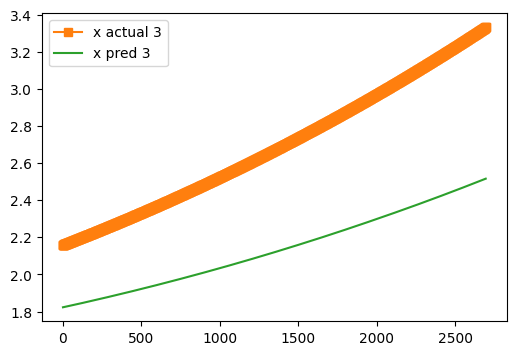

In [121]:
import matplotlib.pyplot as plt
func = 2
plt.figure(figsize=(6, 4))
plt.plot(y_test3[:,0], 's-',color='C1', label=f'x actual {func+1}')
plt.plot(preds_x[func], '-',color='C2', label=f'x pred {func+1}')

try:
    plt.plot(y_test3[:,1], 's-',color='C0', label=f'u actual {func+1}')
    plt.plot(preds_u[func], '-',color='C3', label=f'u pred {func+1}')
except:
    pass
plt.legend()